In [1]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === Load data ===
train = pd.read_csv("/kaggle/input/preprocessing-2/train_processed.csv")
test  = pd.read_csv("/kaggle/input/preprocessing-2/test_processed.csv")

In [2]:
# === Setup ===
TARGET = "HotelValue"
features = [c for c in train.columns if c not in ["Id", TARGET]]

# Separate numeric & categorical columns
num_cols = train[features].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train[features].select_dtypes(exclude=[np.number]).columns.tolist()

# === Impute missing values ===
imputer = SimpleImputer(strategy='median')
train[num_cols] = imputer.fit_transform(train[num_cols])
test[num_cols] = imputer.transform(test[num_cols])

for col in cat_cols:
    mode_val = train[col].mode()[0]
    train[col].fillna(mode_val, inplace=True)
    test[col].fillna(mode_val, inplace=True)

# === Log-transform target and plot skewness ===
y = train[TARGET]
y_log = np.log1p(y)

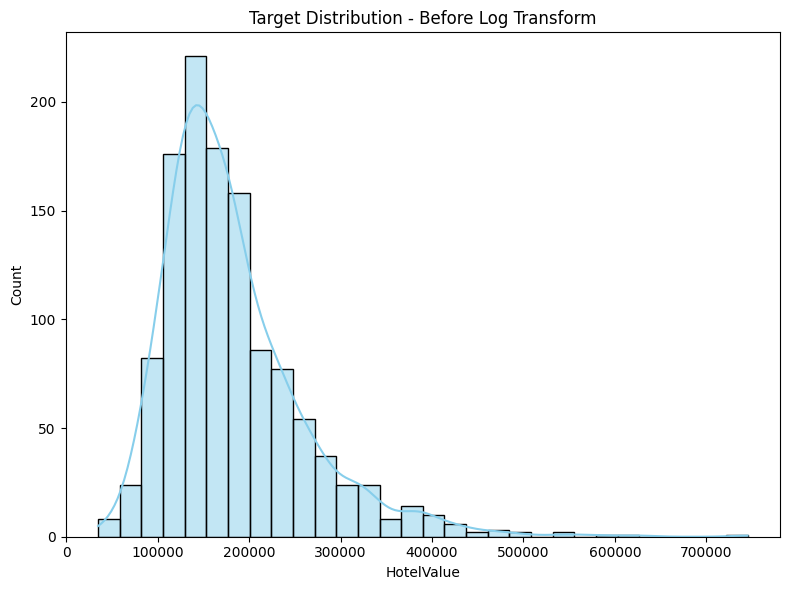

In [3]:
# --- Skewness before and after log-transform ---
plt.figure(figsize=(8,6))
sns.histplot(y, bins=30, kde=True, color='skyblue')
plt.title("Target Distribution - Before Log Transform")
plt.xlabel("HotelValue")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

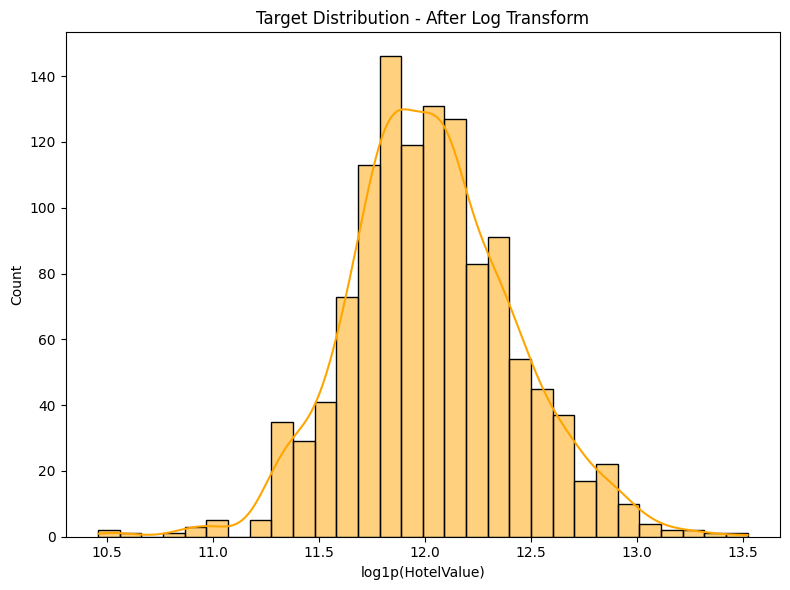

In [4]:
plt.figure(figsize=(8,6))
sns.histplot(y_log, bins=30, kde=True, color='orange')
plt.title("Target Distribution - After Log Transform")
plt.xlabel("log1p(HotelValue)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [5]:
# === Target encoding categorical features ===
te = TargetEncoder(cols=cat_cols)
train[cat_cols] = te.fit_transform(train[cat_cols], y_log)
test[cat_cols] = te.transform(test[cat_cols])

# === Train/validation split ===
X = train[features]
X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)

# === Scale numeric features ===
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

In [6]:
# === Final Models ===
rf_params = {
    'n_estimators': 800,
    'max_depth': 14,
    'min_samples_split': 8,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 8000,
    'learning_rate': 0.015,
    'num_leaves': 40,
    'max_depth': -1,
    'min_data_in_leaf': 40,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'reg_alpha': 0.8,
    'reg_lambda': 1.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

In [7]:
rf_final = RandomForestRegressor(**rf_params).fit(X_train, y_train)
lgb_final = lgb.LGBMRegressor(**lgb_params).fit(X_train, y_train)

# --- Blend models on validation set ---
rf_pred = np.expm1(rf_final.predict(X_valid))
lgb_pred = np.expm1(lgb_final.predict(X_valid))

best_w, best_rmse = 0, np.inf
for w in np.arange(0, 1.05, 0.05):
    y_valid_pred = w*rf_pred + (1-w)*lgb_pred
    rmse = mean_squared_error(np.expm1(y_valid), y_valid_pred, squared=False)
    if rmse < best_rmse:
        best_rmse, best_w = rmse, w
print(f"Best weight: {best_w:.2f}, Validation RMSE: {best_rmse:.2f}")

Best weight: 0.00, Validation RMSE: 26594.33


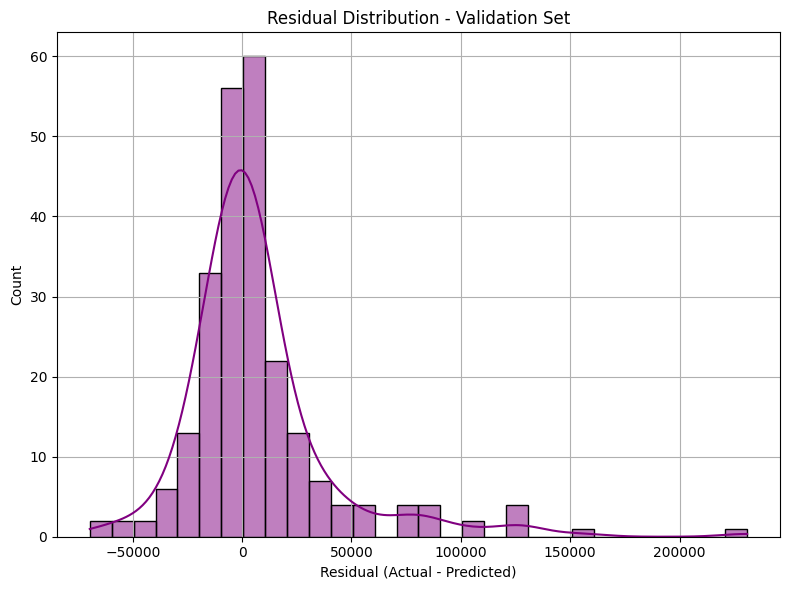

In [8]:
# --- Residuals Plot ---
residuals = np.expm1(y_valid) - y_valid_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.title("Residual Distribution - Validation Set")
plt.grid(True)
plt.tight_layout()
plt.show()

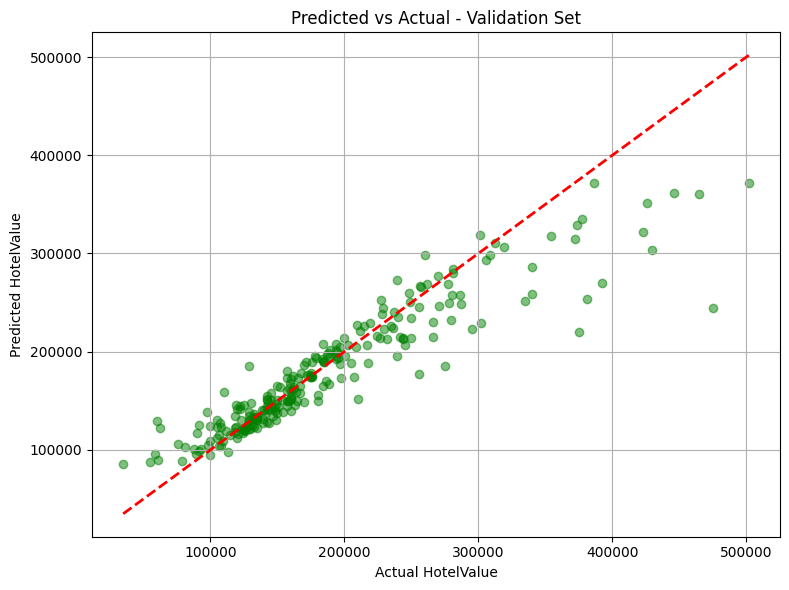

In [9]:
# --- Predicted vs Actual Plot ---
plt.figure(figsize=(8,6))
plt.scatter(np.expm1(y_valid), y_valid_pred, alpha=0.5, color='green')
plt.plot([np.expm1(y_valid).min(), np.expm1(y_valid).max()],
         [np.expm1(y_valid).min(), np.expm1(y_valid).max()], 'r--', lw=2)
plt.xlabel("Actual HotelValue")
plt.ylabel("Predicted HotelValue")
plt.title("Predicted vs Actual - Validation Set")
plt.grid(True)
plt.tight_layout()
plt.show()

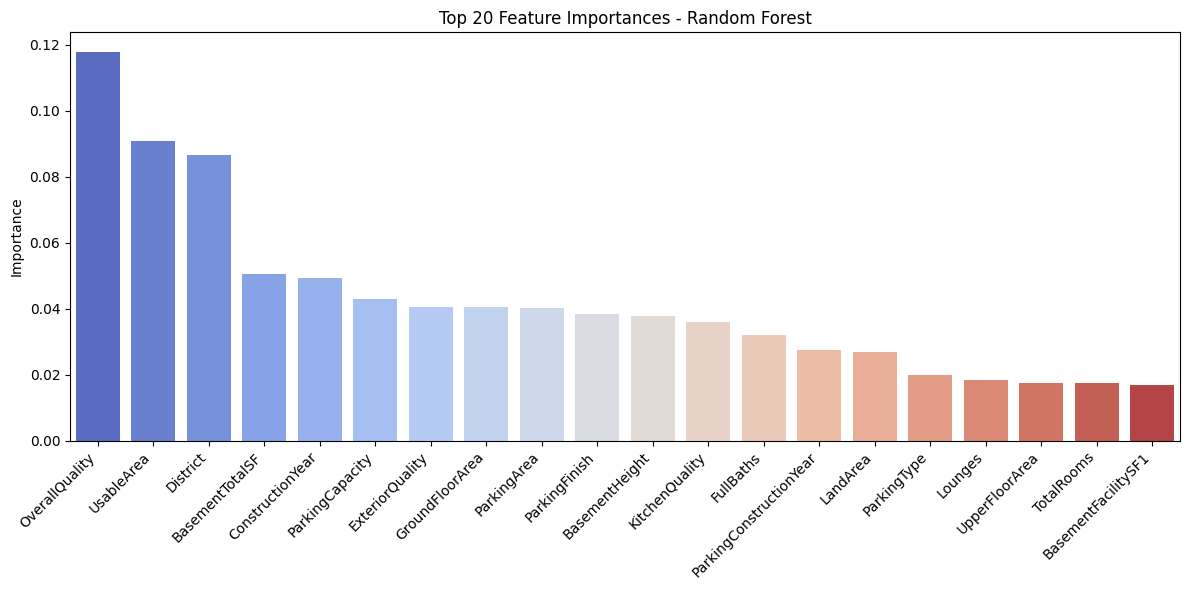

In [10]:
# --- Feature Importances: Random Forest ---
rf_importances = rf_final.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(12,6))
sns.barplot(x=[features[i] for i in rf_indices[:20]], y=rf_importances[rf_indices][:20], palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.title("Top 20 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

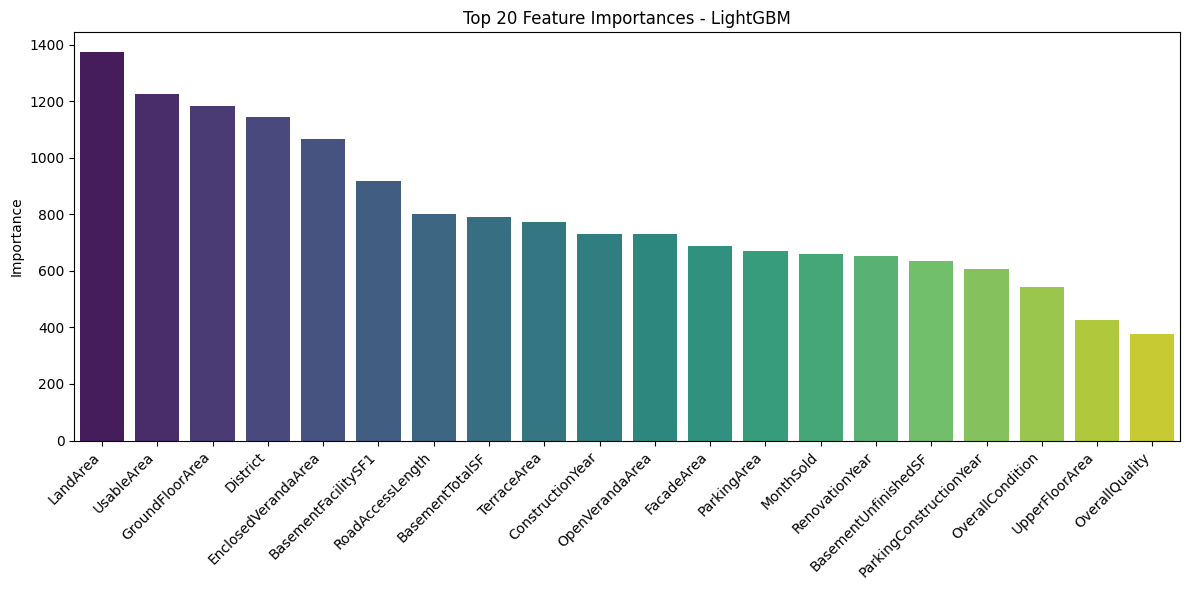

In [11]:
# --- Feature Importances: LightGBM ---
lgb_importances = lgb_final.feature_importances_
lgb_indices = np.argsort(lgb_importances)[::-1]

plt.figure(figsize=(12,6))
sns.barplot(x=[features[i] for i in lgb_indices[:20]], y=lgb_importances[lgb_indices][:20], palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.title("Top 20 Feature Importances - LightGBM")
plt.tight_layout()
plt.show()

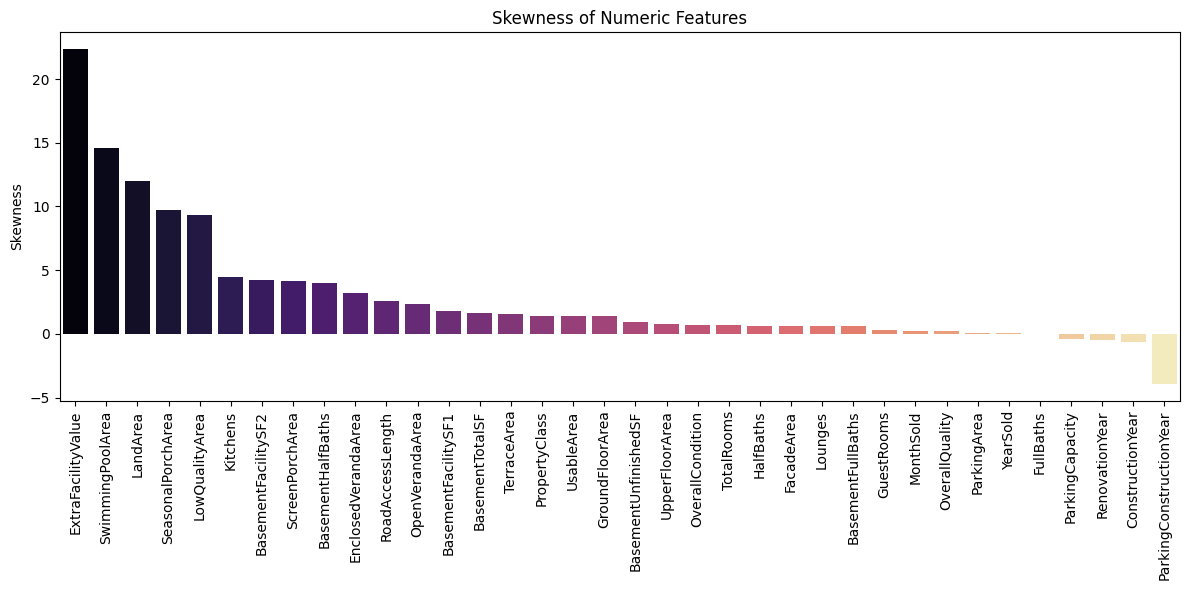

In [12]:
# --- Skewness of numeric features ---
skew_vals = train[num_cols].skew().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=skew_vals.index, y=skew_vals.values, palette="magma")
plt.xticks(rotation=90)
plt.ylabel("Skewness")
plt.title("Skewness of Numeric Features")
plt.tight_layout()
plt.show()

In [13]:
# === Predict on test set & create submission ===
X_test = test[features]
y_test_pred = best_w * np.expm1(rf_final.predict(X_test)) + (1 - best_w) * np.expm1(lgb_final.predict(X_test))
submission = pd.DataFrame({"Id": test["Id"], "HotelValue": y_test_pred})
submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")

Submission file created successfully!
